## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
# read the dataset
retail_df = pd.read_excel("States.xlsx", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,Area Name,Illiterate,Graduate & above,Total - Population,Percentage Illiterate,Percentage Graduate & above
0,State - JAMMU & KASHMIR,3378518,385463,12541302,26.939133,3.073549
1,State - HIMACHAL PRADESH,963742,267936,6864602,14.039299,3.903154
2,State - PUNJAB,4886265,979525,27743338,17.612390,3.530667
3,State - CHANDIGARH,175200,91276,1055450,16.599555,8.648065
4,State - UTTARAKHAND,1929236,525301,10086292,19.127307,5.208069


In [9]:
# basics of the df
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
Area Name                      35 non-null object
Illiterate                     35 non-null int64
Graduate & above               35 non-null int64
Total - Population             35 non-null int64
Percentage Illiterate          35 non-null float64
Percentage Graduate & above    35 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.7+ KB


# 2. Clean the data

In [6]:
# missing values
round(100*(retail_df.isnull().sum())/len(retail_df), 2)

Area Name                      0.0
Illiterate                     0.0
Graduate & above               0.0
Total - Population             0.0
Percentage Illiterate          0.0
Percentage Graduate & above    0.0
dtype: float64

# 3. Prepare the data for modelling

{'whiskers': [<matplotlib.lines.Line2D at 0x14b1d93dac8>,
 'caps': [<matplotlib.lines.Line2D at 0x14b1d93def0>,
 'boxes': [<matplotlib.lines.Line2D at 0x14b1d93d6d8>],
 'medians': [<matplotlib.lines.Line2D at 0x14b1d934828>],
 'fliers': [<matplotlib.lines.Line2D at 0x14b1d934b70>],
 'means': []}

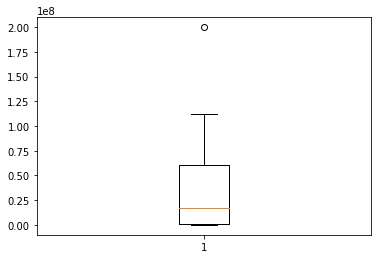

In [10]:
# 1. outlier treatment
plt.boxplot(retail_df['Total - Population'])

In [391]:
# two types of outliers:
# - statistical
# - domain specific

In [392]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [11]:
retail_df.head()

,Area Name,Illiterate,Graduate & above,Total - Population,Percentage Illiterate,Percentage Graduate & above
0,State - JAMMU & KASHMIR,3378518,385463,12541302,26.939133,3.073549
1,State - HIMACHAL PRADESH,963742,267936,6864602,14.039299,3.903154
2,State - PUNJAB,4886265,979525,27743338,17.612390,3.530667
3,State - CHANDIGARH,175200,91276,1055450,16.599555,8.648065
4,State - UTTARAKHAND,1929236,525301,10086292,19.127307,5.208069


In [12]:
# 2. rescaling
rfm_df = retail_df[['Total - Population', 'Percentage Illiterate', 'Percentage Graduate & above']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(35, 3)

In [13]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Total - Population', 'Percentage Illiterate', 'Percentage Graduate & above']
rfm_df_scaled.head()

,Total - Population,Percentage Illiterate,Percentage Graduate & above
0,-0.503383,1.203902,-0.250185
1,-0.632950,-1.067532,0.256526
2,-0.156405,-0.438373,0.029016
3,-0.765541,-0.616716,3.154645
4,-0.559417,-0.171623,1.053547


# 4. Modelling

In [14]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [15]:
kmeans.labels_

array([2, 1, 1, 3, 1, 1, 3, 2, 0, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2,
       2, 0, 1, 2, 0, 0, 0, 1, 1, 1, 0, 3, 1])

In [16]:
# help(KMeans)

## Finding the Optimal Number of Clusters

### SSD

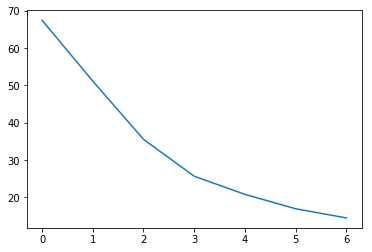

In [17]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [18]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.302168276792436
For n_clusters=3, the silhouette score is 0.2829456907825725
For n_clusters=4, the silhouette score is 0.3518695554523517
For n_clusters=5, the silhouette score is 0.3593293065049708
For n_clusters=6, the silhouette score is 0.32215476595389575
For n_clusters=7, the silhouette score is 0.31361787689932463
For n_clusters=8, the silhouette score is 0.30539205834044086


In [19]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_

array([0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 2, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1])

In [21]:
# assign the label
rfm_df_scaled['cluster_id'] = kmeans.labels_
rfm_df_scaled.head()

,Total - Population,Percentage Illiterate,Percentage Graduate & above,cluster_id
0,-0.503383,1.203902,-0.250185,0
1,-0.632950,-1.067532,0.256526,1
2,-0.156405,-0.438373,0.029016,1
3,-0.765541,-0.616716,3.154645,1
4,-0.559417,-0.171623,1.053547,1


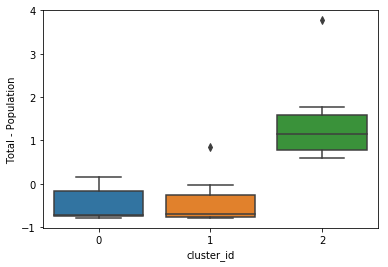

In [26]:
# plot
sns.boxplot(x='cluster_id', y='Total - Population', data=rfm_df_scaled)

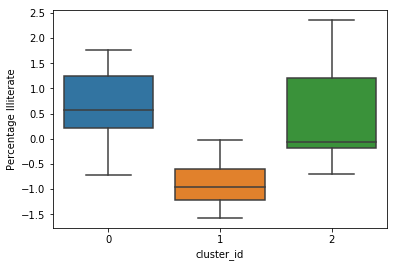

In [27]:
# plot
sns.boxplot(x='cluster_id', y='Percentage Illiterate', data=rfm_df_scaled)

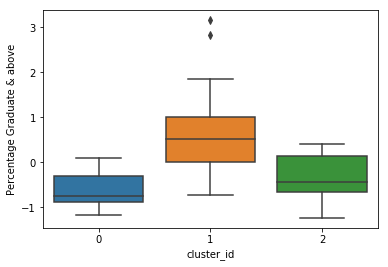

In [28]:
# plot
sns.boxplot(x='cluster_id', y='Percentage Graduate & above', data=rfm_df_scaled)

## Hierarchical Clustering

In [406]:
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [407]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


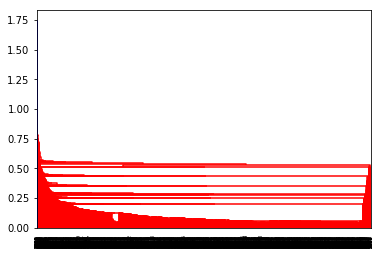

In [408]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

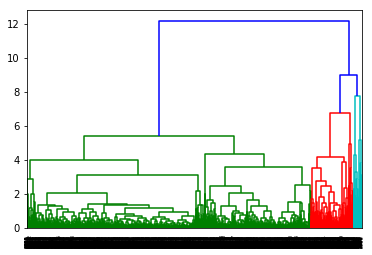

In [409]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [415]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [416]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


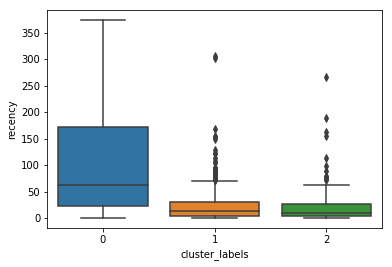

In [419]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

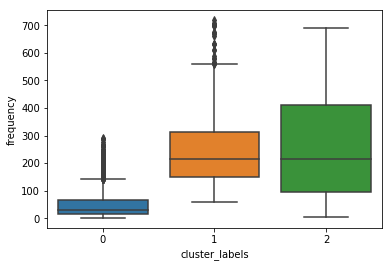

In [420]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

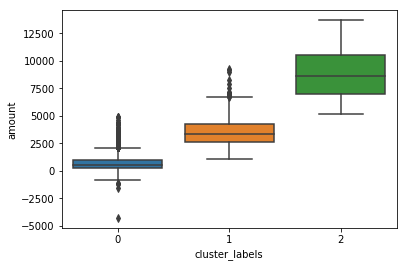

In [421]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)